In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt

In [2]:
# this are periods when 1,2,3,4 HEs were under operation
time_periods = [
    ("2022-10-17","2022-10-21"), ("2022-11-08","2022-11-11"), ("2022-11-15","2022-11-18"),
    ("2022-11-22","2022-11-25"), ("2022-11-29","2022-12-02"), ("2022-12-05","2022-12-09"), 
    ("2022-12-12","2022-12-16"), ("2022-12-19","2022-12-23"), ("2023-01-10","2023-01-13"), 
    ("2023-01-16","2023-01-19"), ("2023-01-24","2023-01-27"), ("2023-01-31","2023-02-03"), 
    ("2023-02-07","2023-02-09"), ("2023-02-13","2023-02-17"), ("2023-02-28","2023-03-03"), 
    ("2023-03-06","2023-03-07"), ("2023-03-09","2023-03-10"), ("2023-03-14","2023-03-17"),
    ("2023-03-21","2023-03-24"),
    ("2023-03-27","2023-03-31"), ("2023-04-03","2023-04-07"), ("2023-04-10","2023-04-14")
]

### All IDs used
* 299 Т1к после ТО
* 309 Р2контура
* 317 Т2к перед ТО
* 319 Т2к после ТО
* 325 Т2к выхТО1
* 327 Твозвуха
* 381 Iвг1
* 395 Iвг2
* 396 Iвг3
* 460 Т2к выхТО2
* 461 Т2к выхТО3
* 462 Т2к выхТО4
* 463 Т2к выхТО5
* 481 Q2контура
#### Second loop I pumps id
* 406 2-1
* 407 2-2
* 408 2-3
* 409 2-4

In [3]:
sys.path.insert(0, os.path.join(os.path.split(os.path.abspath(""))[0], "app"))

In [4]:
from preprocessing import CsvRefactorer
from analytics import WaterFlowRates

In [5]:
# key ids 317, 319, 325, 460, 461, 462, 463, 327
df_refacP1 = CsvRefactorer.read_csv("P1_second_circuit_data_171022_to_140423.csv")
df_refacP2 = CsvRefactorer.read_csv("P2_second_circuit_data_171022_to_140423.csv")

In [6]:
ids1 = df_refacP1.df["ID"].unique()
ids2 = df_refacP2.df["ID"].unique()

In [7]:
ids1_array = df_refacP1.select_by_ids(ids1)
ids2_array = df_refacP2.select_by_ids(ids2)

In [8]:
group1 = df_refacP1.min_frac_groupby(10, *ids1_array)
group2 = df_refacP2.min_frac_groupby(10, *ids2_array)

In [9]:
df1 = df_refacP1.concat_dfs(group1)
df2 = df_refacP2.concat_dfs(group2)

In [10]:
df = pd.concat([df1, df2], axis=1)

In [11]:
# quick TCF categorizing ( set 0 or 1)

df[381] = np.where(df[381] > 20, 0, 1)
df[395] = np.where(df[395] > 20, 0, 1)
df[396] = np.where(df[396] > 20, 0, 1)

In [12]:
periods = df_refacP1.select_time_period(
    df,
    time_periods
)

In [13]:
periods

{'2022-10-17 2022-10-21':                       309   317   319        325       327  381  395  396  \
 Timestamp                                                                   
 2022-10-17 09:20:00  0.01  16.5  21.4  20.100000  4.200000    1    1    1   
 2022-10-17 09:30:00  0.01  16.5  21.4  20.090909  4.308333    1    1    1   
 2022-10-17 09:40:00  0.01  16.5  21.4  20.068421  4.388572    1    1    1   
 2022-10-17 09:50:00  0.01  16.5  21.4  20.030769  4.600000    1    1    1   
 2022-10-17 10:00:00  0.01  16.5  21.4  20.014286  4.768571    1    1    1   
 ...                   ...   ...   ...        ...       ...  ...  ...  ...   
 2022-10-21 23:10:00   NaN   NaN   NaN        NaN       NaN    1    1    1   
 2022-10-21 23:20:00   NaN   NaN   NaN        NaN       NaN    1    1    1   
 2022-10-21 23:30:00   NaN   NaN   NaN        NaN       NaN    1    1    1   
 2022-10-21 23:40:00   NaN   NaN   NaN        NaN       NaN    1    1    1   
 2022-10-21 23:50:00   NaN   NaN   NaN 

In [14]:
wfr_anal = WaterFlowRates(0.1)

In [78]:
periods_ftrd = {}

for i in periods.keys():
    periods_ftrd[i], _ = wfr_anal.df_md_filter(periods[i], 481)

In [79]:
# quick NaN handling

for i in periods.keys():
    periods_ftrd[i] = periods_ftrd[i].fillna(0.0)
    zero_pressure = periods_ftrd[i][periods_ftrd[i][309] == 0.0].index
    zero_currents = periods_ftrd[i][
        (periods_ftrd[i][406] == 0.0) &
        (periods_ftrd[i][407] == 0.0) &
        (periods_ftrd[i][408] == 0.0) &
        (periods_ftrd[i][409] == 0.0)
    ].index
    # drop rows where pressure is nill
    periods_ftrd[i] = periods_ftrd[i].drop(index=zero_pressure)
    periods_ftrd[i] = periods_ftrd[i].drop(index=zero_currents)
    

In [80]:
periods_ftrd

{'2022-10-17 2022-10-21':                           309        317        319        325       327  381  \
 Timestamp                                                                       
 2022-10-17 15:10:00  0.450000  14.353125  16.441667  16.337838  9.247222    1   
 2022-10-17 15:20:00  0.450000  14.747059  17.215789  17.100000  9.481579    1   
 2022-10-17 15:30:00  0.450000  15.345946  18.567500  18.510000  9.726316    1   
 2022-10-17 15:40:00  0.450000  16.150000  20.095000  19.945000  9.594286    1   
 2022-10-17 15:50:00  0.450000  17.255000  21.485000  21.322500  9.352778    1   
 ...                       ...        ...        ...        ...       ...  ...   
 2022-10-21 18:40:00  0.450000  21.530555  28.265714  27.854054  6.234286    0   
 2022-10-21 18:50:00  0.450000  20.987879  27.696970  27.300000  6.139394    0   
 2022-10-21 19:00:00  0.451538  20.538889  25.662500  25.040000  6.163636    0   
 2022-10-21 19:10:00  0.452941  19.794737  23.000000  22.575000  6.272973

In [81]:
# TO get right Imean the following approach suggested
for i in periods.keys():
    
    try:
        periods_ftrd[i]["I2mean"] = periods_ftrd[i].loc[:, [406, 407, 408, 409]].sum(axis=1)/3
        
        # drop 406,407,408,409
        periods_ftrd[i] = periods_ftrd[i].drop([406, 407, 408, 409], axis=1)
    except KeyError:
        print("Some of cols have been dropped already")
    print(periods_ftrd[i])

                          309        317        319        325       327  381  \
Timestamp                                                                       
2022-10-17 15:10:00  0.450000  14.353125  16.441667  16.337838  9.247222    1   
2022-10-17 15:20:00  0.450000  14.747059  17.215789  17.100000  9.481579    1   
2022-10-17 15:30:00  0.450000  15.345946  18.567500  18.510000  9.726316    1   
2022-10-17 15:40:00  0.450000  16.150000  20.095000  19.945000  9.594286    1   
2022-10-17 15:50:00  0.450000  17.255000  21.485000  21.322500  9.352778    1   
...                       ...        ...        ...        ...       ...  ...   
2022-10-21 18:40:00  0.450000  21.530555  28.265714  27.854054  6.234286    0   
2022-10-21 18:50:00  0.450000  20.987879  27.696970  27.300000  6.139394    0   
2022-10-21 19:00:00  0.451538  20.538889  25.662500  25.040000  6.163636    0   
2022-10-21 19:10:00  0.452941  19.794737  23.000000  22.575000  6.272973    0   
2022-10-21 19:20:00  0.45440

In [82]:
# Noimalize Q by P and Imean
for i in periods.keys():
    
    try:
        # QbyIP units are m3/h/MPa/A
        periods_ftrd[i]["QbyIP"] = periods_ftrd[i][481]/(periods_ftrd[i][309]*periods_ftrd[i]["I2mean"])
        # drop 406,407,408,409
        periods_ftrd[i] = periods_ftrd[i].drop([481, 309, "I2mean"], axis=1)
    except KeyError:
        print("Some of cols have been dropped already")
    print(periods_ftrd[i])

                           317        319        325       327  381  395  396  \
Timestamp                                                                       
2022-10-17 15:10:00  14.353125  16.441667  16.337838  9.247222    1    1    1   
2022-10-17 15:20:00  14.747059  17.215789  17.100000  9.481579    1    1    1   
2022-10-17 15:30:00  15.345946  18.567500  18.510000  9.726316    1    1    1   
2022-10-17 15:40:00  16.150000  20.095000  19.945000  9.594286    1    1    1   
2022-10-17 15:50:00  17.255000  21.485000  21.322500  9.352778    1    1    1   
...                        ...        ...        ...       ...  ...  ...  ...   
2022-10-21 18:40:00  21.530555  28.265714  27.854054  6.234286    0    0    0   
2022-10-21 18:50:00  20.987879  27.696970  27.300000  6.139394    0    0    0   
2022-10-21 19:00:00  20.538889  25.662500  25.040000  6.163636    0    0    0   
2022-10-21 19:10:00  19.794737  23.000000  22.575000  6.272973    0    0    0   
2022-10-21 19:20:00  18.6736

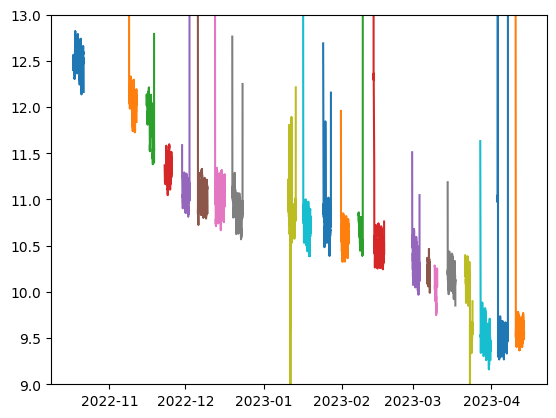

In [83]:
# quick view of df

for i in periods_ftrd.keys():
    plt.plot(periods_ftrd[i]["QbyIP"])
    plt.ylim(9,13)

In [84]:
# try to apply double filtering

for i in periods_ftrd.keys():
    periods_ftrd[i], _ = wfr_anal.df_md_filter(periods_ftrd[i], "QbyIP")

In [85]:
print(periods_ftrd)

{'2022-10-17 2022-10-21':                            317        319        325       327  381  395  396  \
Timestamp                                                                       
2022-10-17 15:10:00  14.353125  16.441667  16.337838  9.247222    1    1    1   
2022-10-17 15:20:00  14.747059  17.215789  17.100000  9.481579    1    1    1   
2022-10-17 15:30:00  15.345946  18.567500  18.510000  9.726316    1    1    1   
2022-10-17 15:40:00  16.150000  20.095000  19.945000  9.594286    1    1    1   
2022-10-17 15:50:00  17.255000  21.485000  21.322500  9.352778    1    1    1   
...                        ...        ...        ...       ...  ...  ...  ...   
2022-10-21 18:40:00  21.530555  28.265714  27.854054  6.234286    0    0    0   
2022-10-21 18:50:00  20.987879  27.696970  27.300000  6.139394    0    0    0   
2022-10-21 19:00:00  20.538889  25.662500  25.040000  6.163636    0    0    0   
2022-10-21 19:10:00  19.794737  23.000000  22.575000  6.272973    0    0    0   
20

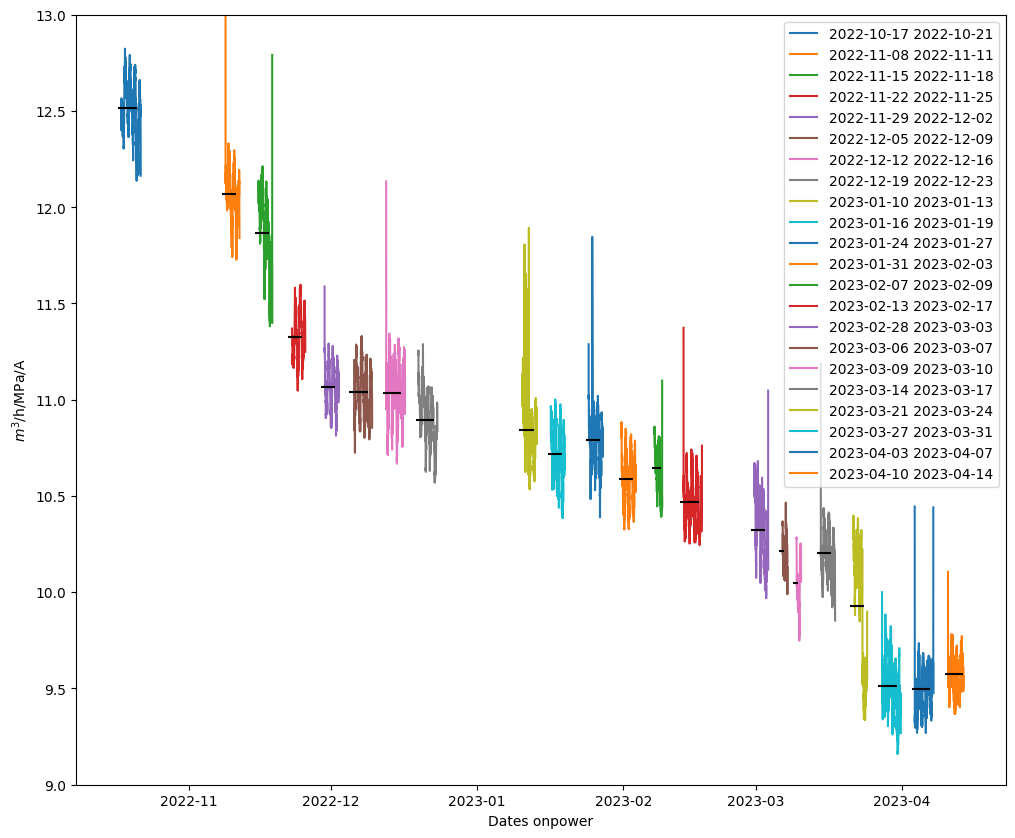

In [86]:
# new quick view of df
plt.figure(figsize = (12,10))

for n, i in enumerate(periods_ftrd.keys()):
    
    s,f = list(periods_ftrd.keys())[n].split(" ")
    plt.plot(periods_ftrd[i]["QbyIP"], label=i)
    q_mean = periods_ftrd[i]["QbyIP"].mean()
    plt.hlines(q_mean, pd.to_datetime(s), pd.to_datetime(f), color="black")
    plt.xlabel("Dates onpower")
    plt.ylabel("$m^3$/h/MPa/A")
    plt.legend()
    plt.ylim(9,13)

In [87]:
# to make clear dataset extra data engineering steps are required
# 1 - temporary drop temperature on each HE
# 2 - get delta t on second circuit

# 1 step
t_on_HE = {}

for i in periods_ftrd.keys():
    
    try:
        t_on_HE[i] = periods_ftrd[i].loc[:, [325, 460, 461, 462, 463, 319]]
        periods_ftrd[i] = periods_ftrd[i].drop([325, 460, 461, 462, 463], axis=1)
        
    except KeyError:
        print("Some of cols have been dropped already")

In [88]:
t_on_HE

{'2022-10-17 2022-10-21':                            325        460        461        462        463  \
 Timestamp                                                                    
 2022-10-17 15:10:00  16.337838  16.588261  17.147183  16.873704  20.283652   
 2022-10-17 15:20:00  17.100000  17.330882  17.989984  17.645395  20.281205   
 2022-10-17 15:30:00  18.510000  18.602798  19.464381  18.993116   0.000000   
 2022-10-17 15:40:00  19.945000  20.050474  21.099893  20.482048  20.277330   
 2022-10-17 15:50:00  21.322500  21.415636  22.551818  21.872480  20.280311   
 ...                        ...        ...        ...        ...        ...   
 2022-10-21 18:40:00  27.854054  27.916538  29.866786  28.359517  30.815130   
 2022-10-21 18:50:00  27.300000  27.353255  29.295228  27.792991  30.821466   
 2022-10-21 19:00:00  25.040000  25.466401  26.973334  25.720650  30.824446   
 2022-10-21 19:10:00  22.575000  23.005530  24.004861  23.143500  30.830038   
 2022-10-21 19:20:00  20.62

In [89]:
dt_on_HE = {}

for i in periods_ftrd.keys():
    dt_on_HE[i] = t_on_HE[i].apply(lambda x: x - periods_ftrd[i][317])

In [90]:
wt_he = WaterTemperatures(0.15)
# quick filter to reduce dispersion
for i in dt_on_HE.keys():
    dt_on_HE[i], _ = wt_he.df_md_filter(dt_on_HE[i], 319)
    

In [91]:
dt_on_HE

{'2022-10-17 2022-10-21':                           325       460       461       462       463  \
 Timestamp                                                               
 2022-10-17 18:10:00  5.700000  5.858695  7.561717  6.421306 -2.891379   
 2022-10-17 18:20:00  5.703334  5.860860  7.571031  6.431211 -2.721636   
 2022-10-17 18:30:00  5.731150  5.883377  7.594484  6.446256 -2.584630   
 2022-10-17 18:40:00  5.700001  5.846015  7.556182  6.412157 -2.534331   
 2022-10-17 18:50:00  5.700001  5.846473  7.564552  6.410372 -2.490635   
 ...                       ...       ...       ...       ...       ...   
 2022-10-21 17:30:00  5.935485  5.964014  7.804715  6.427595  7.004135   
 2022-10-21 17:40:00  5.993441  5.992733  7.837819  6.456833  7.070750   
 2022-10-21 17:50:00  5.981250  5.988273  7.831771  6.451791  7.069175   
 2022-10-21 18:00:00  5.981048  5.977565  7.823589  6.442031  7.084207   
 2022-10-21 18:10:00  5.903227  5.939477  7.777690  6.404733  6.994528   
 
           

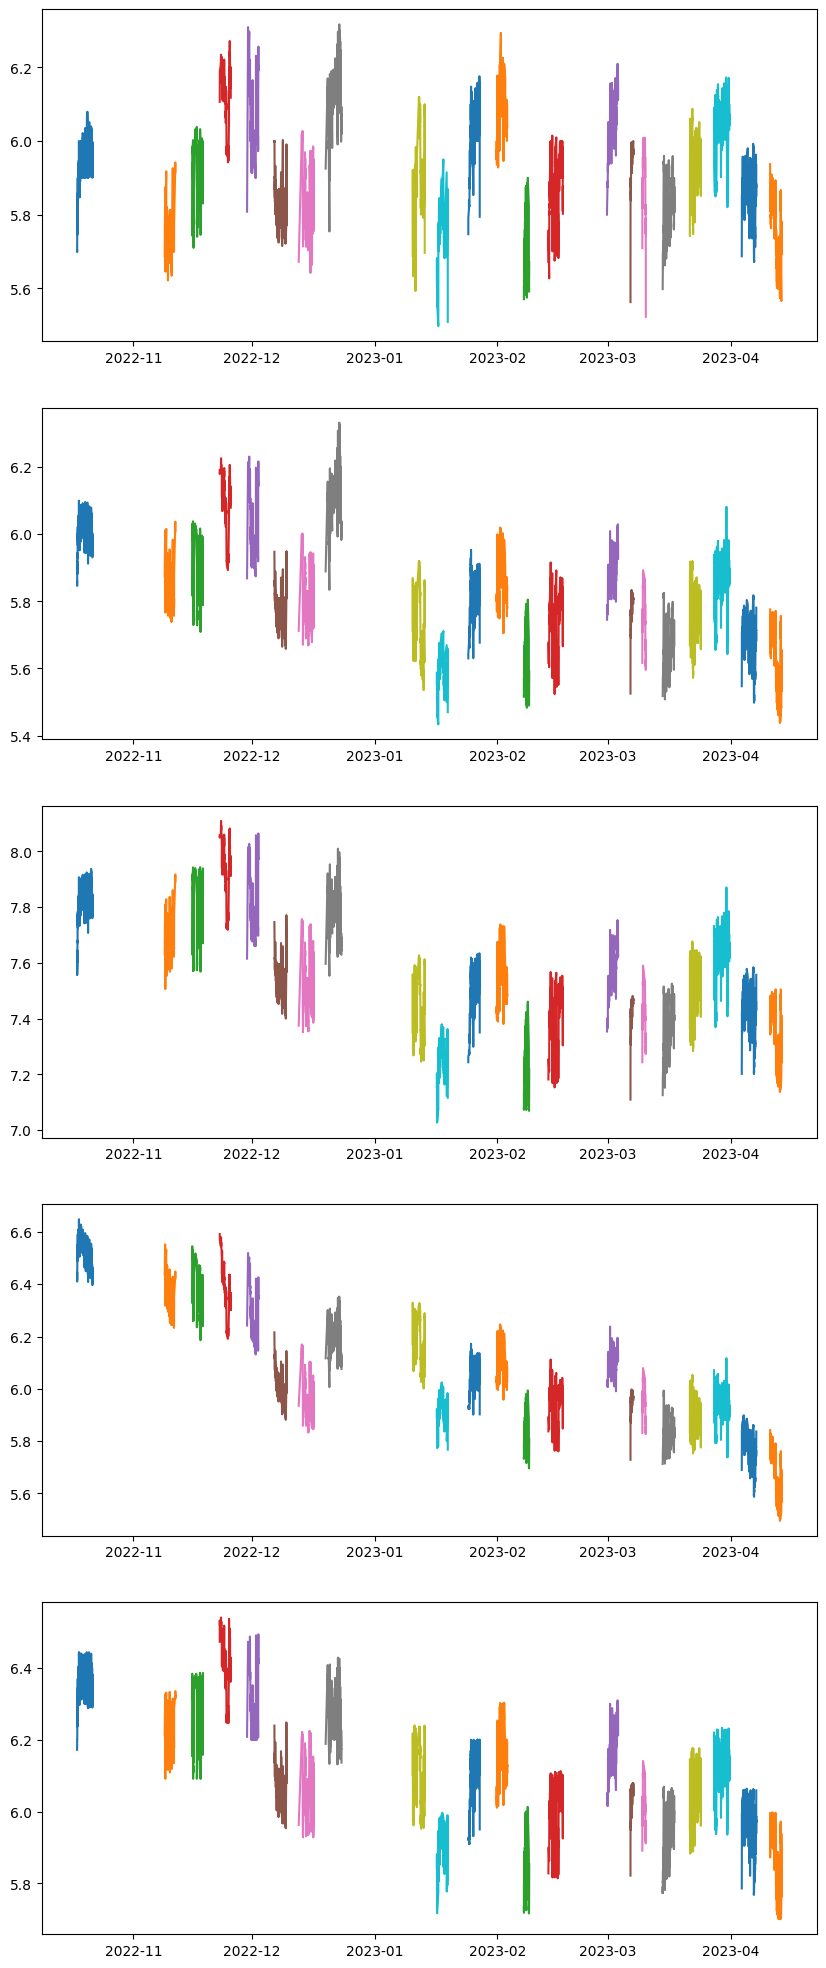

In [92]:
fig, axs = plt.subplots(5,1, figsize=(10,25))
for i in dt_on_HE.keys():
    axs[0].plot(dt_on_HE[i][325])
    axs[1].plot(dt_on_HE[i][460])
    axs[2].plot(dt_on_HE[i][461])
    axs[3].plot(dt_on_HE[i][462])
    axs[4].plot(dt_on_HE[i][319])
    
#     axs[0].set_ylim(4.5,6.5)

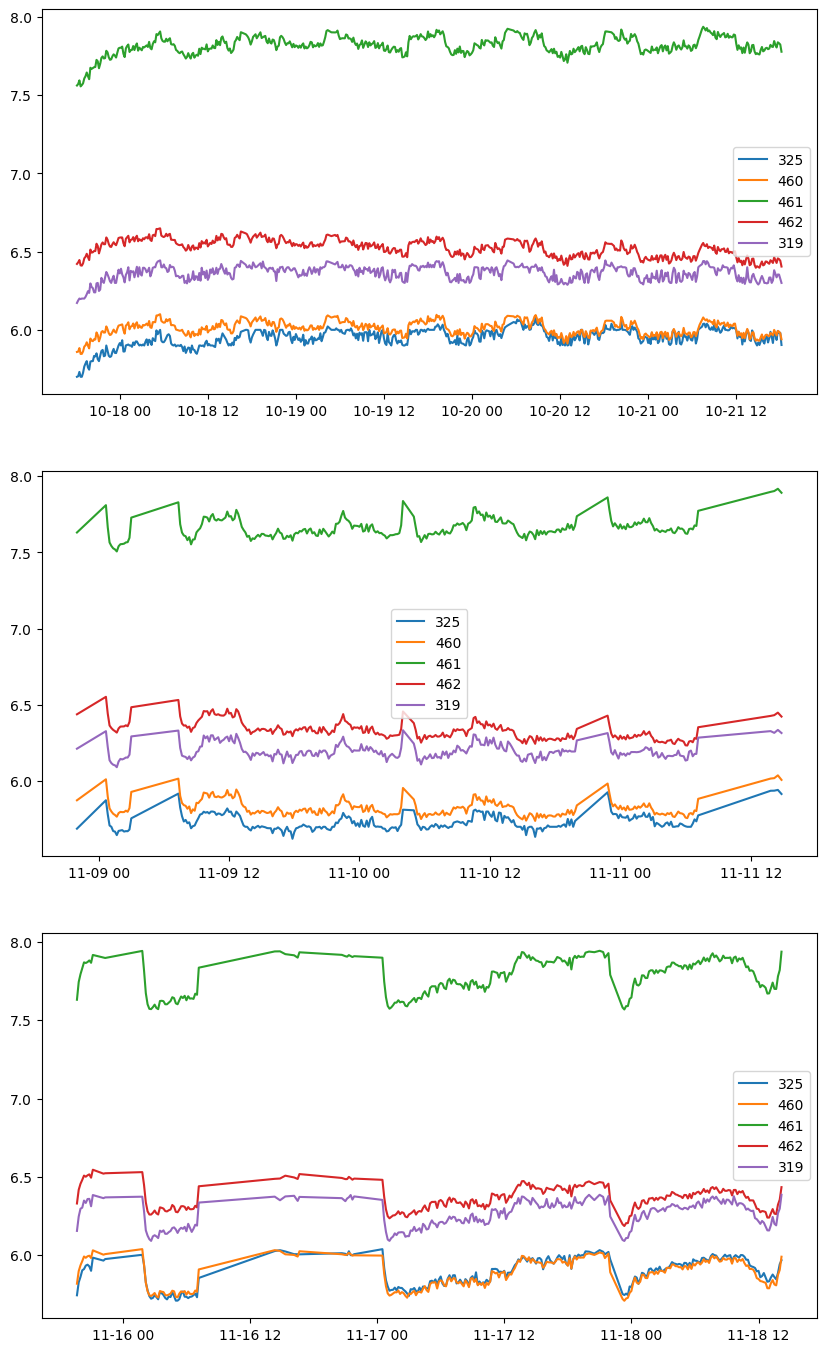

In [93]:
fig, axs = plt.subplots(3,1, figsize=(10,17))
for n,i in enumerate(list(dt_on_HE.keys())[:3]):
    axs[n].plot(dt_on_HE[i].drop(463, axis=1), label=dt_on_HE[i].drop(463, axis=1).columns)
    axs[n].legend()

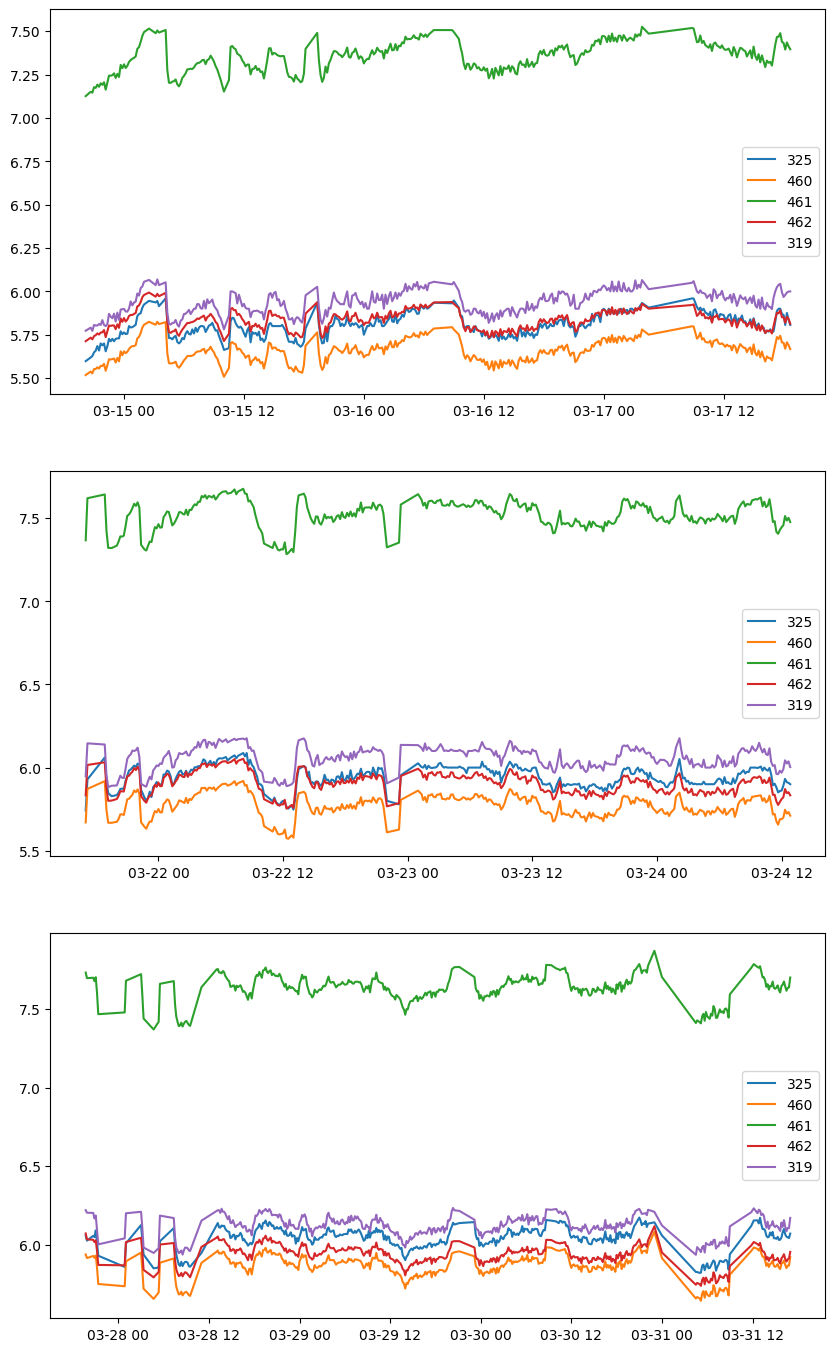

In [97]:
fig, axs = plt.subplots(3,1, figsize=(10,17))
for n,i in enumerate(list(dt_on_HE.keys())[-5:-2]):
    axs[n].plot(dt_on_HE[i].drop(463, axis=1), label=dt_on_HE[i].drop(463, axis=1).columns)
    axs[n].legend()

# About weird results on 3d HE
## As it follows the last time when HE undertook cleaning session was during summer of 2021
## So it means that he is probably fully fouled that is way the water flow rate through the HE super low as result dt rises